<a href="https://colab.research.google.com/github/muneezemalikk/EEG-Automation/blob/main/ML_ASSIGN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EEG Classification using Machine Learning:

**This notebook implements EEG data classification using Logistic Regression, Random Forest, and SVM. It compares model performance on raw data vs engineered features, with class imbalance handled via SMOTE.**


###Set paths
edf_folder = "/Users/muneezemalik/Desktop/EEG/Raw_EDF_Files"
save_folder = "/Users/muneezemalik/Desktop/EEG/EEG_processed"

###Create save directory if it doesn't exist
os.makedirs(save_folder, exist_ok=True)

###Initialize lists
CPS_seizures, elec_seizures, noc_seizures, normals = [], [], [], []
labels = []

for patient in [15, 14, 13, 12, 11, 10]:
    if patient == 10:
        files_list = ["Record1.edf", "Record2.edf"]
    elif patient in (15, 13, 11):
        files_list = ["Record1.edf", "Record2.edf", "Record3.edf", "Record4.edf"]
    elif patient in (14, 12):
        files_list = ["Record1.edf", "Record2.edf", "Record3.edf"]
        
    for file_id, file in enumerate(files_list):
        file_path = os.path.join(edf_folder, f"p{patient}_{file}")
        data = mne.io.read_raw_edf(file_path, preload=True)

        # Channel ordering
        if patient in (15, 14, 13, 12, 11):
            drop_list = ['EEG Cz-Ref', 'EEG Pz-Ref', 'ECG EKG', 'Manual']
            data.drop_channels([ch for ch in drop_list if ch in data.ch_names])
        elif patient == 10:
            reorder_list = ['EEG Fp2-Ref', 'EEG Fp1-Ref', 'EEG F8-Ref', 'EEG F4-Ref', 'EEG Fz-Ref',
                            'EEG F3-Ref', 'EEG F7-Ref', 'EEG A2-Ref', 'EEG T4-Ref', 'EEG C4-Ref',
                            'EEG C3-Ref', 'EEG T3-Ref', 'EEG A1-Ref', 'EEG T6-Ref', 'EEG P4-Ref',
                            'EEG P3-Ref', 'EEG T5-Ref', 'EEG O2-Ref', 'EEG O1-Ref']
            data.reorder_channels(reorder_list)

        raw_data = np.array(data.get_data())
        record_time = datetime.combine(date.today(), data.info['meas_date'].time())
        seizure_list = eval(f'seizures_{patient}')[file_id + 1]

        index_mat = np.array([[0, 0]])
        seizure_record = []

        for sz in seizure_list:
            s_time = datetime.combine(date.today(), time(*sz[:3]))
            seizure_duration = sz[3]
            s_index = int((s_time - record_time).total_seconds() * 500)
            s_index_end = s_index + seizure_duration * 500
            st = raw_data[:, s_index:s_index_end]
            index_mat = np.vstack([index_mat, [s_index, s_index_end]])
            seizure_record = np.concatenate((seizure_record, st), axis=1) if seizure_record != [] else st

        # Remove seizure segments from normal data
        all_sz_indices = np.concatenate([np.arange(start, end) for start, end in index_mat[1:]], axis=0)
        normal_record = np.delete(raw_data, all_sz_indices.astype(int), axis=1)

        for i in range(seizure_duration):
            sz_sample = seizure_record[:, i*500:(i+1)*500]
            if patient == 10:
                elec_seizures.append(sz_sample)
            elif patient == 13 and file_id < 3:
                noc_seizures.append(sz_sample)
            else:
                CPS_seizures.append(sz_sample)
            normals.append(normal_record[:, i*500:(i+1)*500])

### Normalize and stack
def normalize(arr):
    arr = np.array(arr)
    return arr / np.amax(np.abs(arr))

CPS_seizures = normalize(CPS_seizures)
elec_seizures = normalize(elec_seizures)
noc_seizures = normalize(noc_seizures)
normals = normalize(normals)

###Combine and label
x = np.vstack((noc_seizures, elec_seizures, CPS_seizures, normals))
labels.extend([3] * len(noc_seizures))
labels.extend([2] * len(elec_seizures))
labels.extend([1] * len(CPS_seizures))
labels.extend([0] * len(normals))

###Split dataset
x_train, x_test, y_train, y_test = train_test_split(x, labels, test_size=0.1, random_state=1)

### Save as .npy
np.save(os.path.join(save_folder, "x_train.npy"), x_train)
np.save(os.path.join(save_folder, "x_test.npy"), x_test)
np.save(os.path.join(save_folder, "y_train.npy"), y_train)
np.save(os.path.join(save_folder, "y_test.npy"), y_test)

###Save as .mat
scipy.io.savemat(os.path.join(save_folder, "x_train.mat"), {"x_train": x_train})
scipy.io.savemat(os.path.join(save_folder, "x_test.mat"), {"x_test": x_test})
scipy.io.savemat(os.path.join(save_folder, "y_train.mat"), {"y_train": y_train})
scipy.io.savemat(os.path.join(save_folder, "y_test.mat"), {"y_test": y_test})

print("✅ Preprocessing complete. Data saved in:", save_folder)


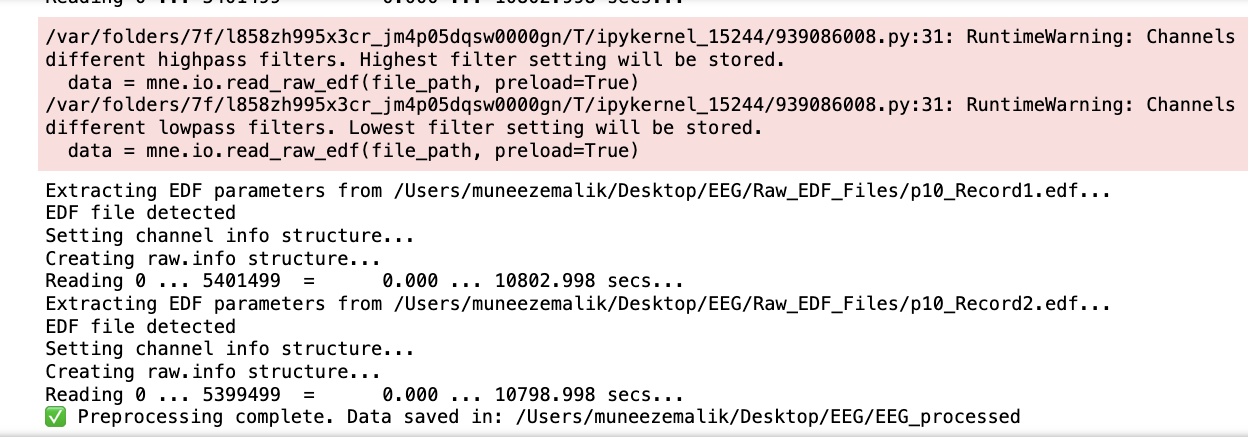

##  📌 Mount Google Drive to access data


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# 📂 Define Data Path

data_path = "/content/drive/MyDrive/EEG_processed"


## 📦 1. Importing Necessary Libraries







In [3]:
# Import all required libraries for data manipulation, visualization, and modeling

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Scikit-learn tools

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# SMOTE for class balancing

from imblearn.over_sampling import SMOTE

# Ignore warnings for clean output

import warnings
warnings.filterwarnings("ignore")


##  📊 2. Load Preprocessed EEG Data

In [42]:
# Set the path where the preprocessed EEG data is stored
data_path = "/content/drive/MyDrive/EEG_processed"

# Load the training and test feature data (EEG signals)
x_train = np.load(os.path.join(data_path, "x_train.npy"))  # Training data (features)
x_test = np.load(os.path.join(data_path, "x_test.npy"))  # Test data (features)

# Load the training and test label data (corresponding class labels)
y_train = np.load(os.path.join(data_path, "y_train.npy"))  # Training labels (classes)
y_test = np.load(os.path.join(data_path, "y_test.npy"))  # Test labels (classes)

# Print the shapes of the loaded training data and labels
print("✅  Data loaded:")
print("x_train shape:", x_train.shape)  # Display shape of training data
print("y_train shape:", y_train.shape)  # Display shape of training labels


✅  Data loaded:
x_train shape: (5499, 19, 500)
y_train shape: (5499,)


##  📉 3. Visualize Class Distribution

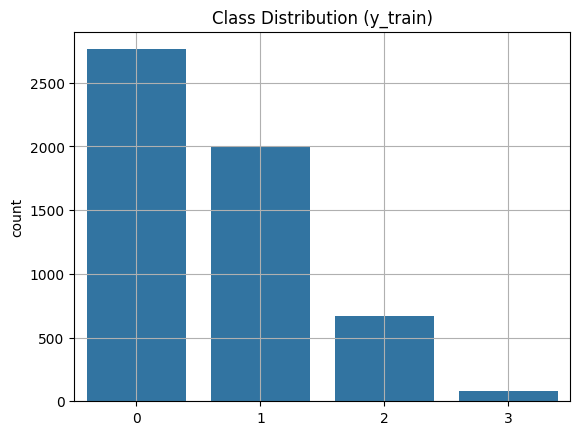

In [41]:
# Create a count plot to visualize the distribution of classes in the training labels (y_train)
sns.countplot(x=y_train)  # Count occurrences of each class and plot them

# Set the title for the plot
plt.title("Class Distribution (y_train)")  # Title of the plot

# Enable gridlines for better readability of the plot
plt.grid(True)  # Show gridlines

# Display the plot
plt.show()  # Show the plot to the user


##🧠 4. Visualize Sample EEG Channels


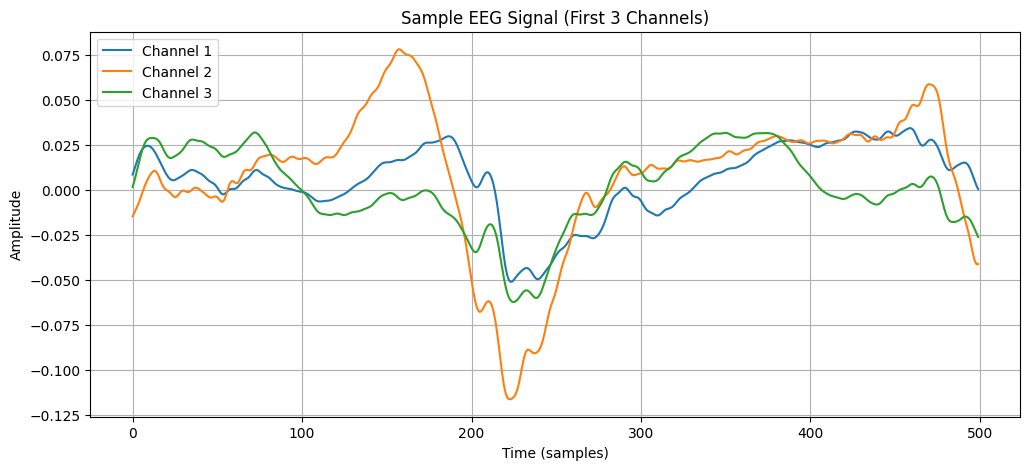

In [40]:
# Set up the figure size for better visualization of the EEG signal
plt.figure(figsize=(12, 5))

# Loop through the first 3 channels of the first sample in the training set and plot their signals
for i in range(3):
    plt.plot(x_train[0][i], label=f'Channel {i+1}')  # Plot the signal for each channel (i+1 for 1-based index)

# Set the title for the plot
plt.title("Sample EEG Signal (First 3 Channels)")  # Title of the plot

# Label the x-axis as "Time (samples)"
plt.xlabel("Time (samples)")  # X-axis label

# Label the y-axis as "Amplitude"
plt.ylabel("Amplitude")  # Y-axis label

# Display a legend to identify the channels
plt.legend()  # Display legend with the channel names

# Enable gridlines for better visualization of the signal
plt.grid(True)  # Show gridlines

# Display the plot
plt.show()  # Show the plot to the user


## 🧩 5. Flatten EEG Data for Basic Models


In [39]:
# Reshape the training data to flatten each image (assuming x_train contains image data)
x_train_flat = x_train.reshape(x_train.shape[0], -1)

# Reshape the test data to flatten each image (assuming x_test contains image data)
x_test_flat = x_test.reshape(x_test.shape[0], -1)

# Print the new shapes of the flattened training and test data
print("✅  Data flattened:")
print("x_train_flat shape:", x_train_flat.shape)  # Print the shape of the flattened training data
print("x_test_flat shape:", x_test_flat.shape)  # Print the shape of the flattened test data


✅  Data flattened:
x_train_flat shape: (5499, 9500)
x_test_flat shape: (611, 9500)


## 🧪 6. Define Training Function for Raw Data

In [38]:
def train_model_basic(model, name):
    # Train the model on the training data (x_train_flat, y_train)
    model.fit(x_train_flat, y_train)

    # Predict the labels for the test data
    y_pred = model.predict(x_test_flat)

    # Calculate the F1 score for the predictions using weighted averaging
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Print the F1 score with the model name
    print(f"🔹 {name} F1 Score (Raw): {f1:.4f}")

    # Print a detailed classification report (precision, recall, f1-score for each class)
    print(classification_report(y_test, y_pred))

    # Return the predicted labels and F1 score
    return y_pred, f1


##  🧠 7. Train Models on Raw EEG Data


In [37]:
# Initialize a Logistic Regression model with a maximum of 1000 iterations
lr = LogisticRegression(max_iter=1000)

# Initialize a Random Forest model with 100 trees and a fixed random state for reproducibility
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Initialize a Support Vector Machine model (SVM) with default parameters
svm = SVC()

# Train the Logistic Regression model and get predictions and F1 score
pred_lr_raw, f1_lr_raw = train_model_basic(lr, "Logistic Regression")

# Train the Random Forest model and get predictions and F1 score
pred_rf_raw, f1_rf_raw = train_model_basic(rf, "Random Forest")

# Train the SVM model and get predictions and F1 score
pred_svm_raw, f1_svm_raw = train_model_basic(svm, "SVM")


🔹 Logistic Regression F1 Score (Raw): 0.4475
              precision    recall  f1-score   support

           0       0.52      0.92      0.66       293
           1       0.61      0.22      0.32       226
           2       0.57      0.05      0.09        83
           3       0.00      0.00      0.00         9

    accuracy                           0.53       611
   macro avg       0.42      0.30      0.27       611
weighted avg       0.55      0.53      0.45       611

🔹 Random Forest F1 Score (Raw): 0.8716
              precision    recall  f1-score   support

           0       0.86      0.95      0.90       293
           1       0.92      0.84      0.88       226
           2       0.85      0.82      0.83        83
           3       0.00      0.00      0.00         9

    accuracy                           0.88       611
   macro avg       0.66      0.65      0.65       611
weighted avg       0.87      0.88      0.87       611

🔹 SVM F1 Score (Raw): 0.6815
              pre

## 🔍 8. Confusion Matrix Plotting Function


In [36]:
def plot_conf_matrix(y_true, y_pred, title):
    # Calculate the confusion matrix from true labels and predicted labels
    cm = confusion_matrix(y_true, y_pred)

    # Create a heatmap to visualize the confusion matrix with annotations
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')  # 'annot=True' adds numbers, 'fmt='d'' formats them as integers

    # Set the title for the plot
    plt.title(title)  # Sets the title passed to the function

    # Label the x-axis as "Predicted" and y-axis as "True"
    plt.xlabel("Predicted")  # Label for the predicted class axis
    plt.ylabel("True")  # Label for the actual true class axis

    # Show the plot
    plt.show()  # Display the heatmap


## 📊 9. Confusion Matrices for Raw Data Models


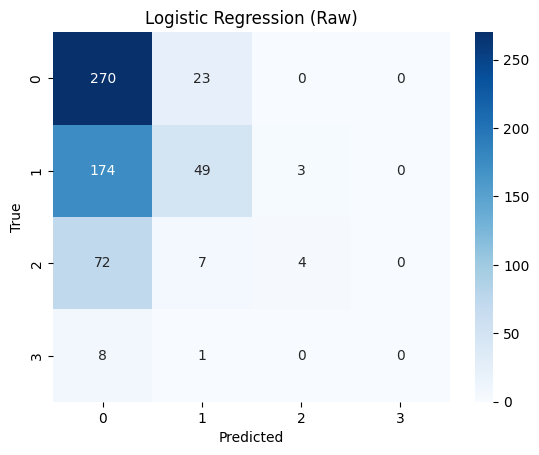

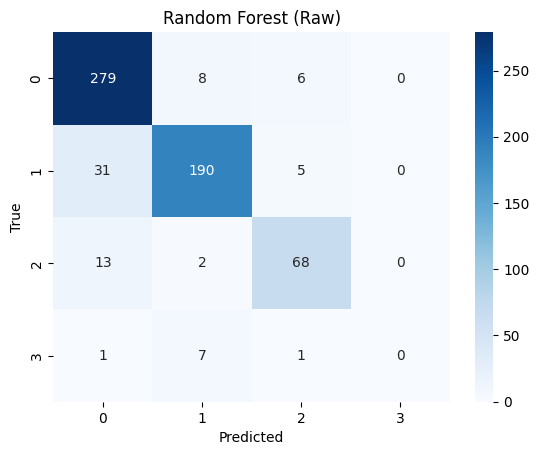

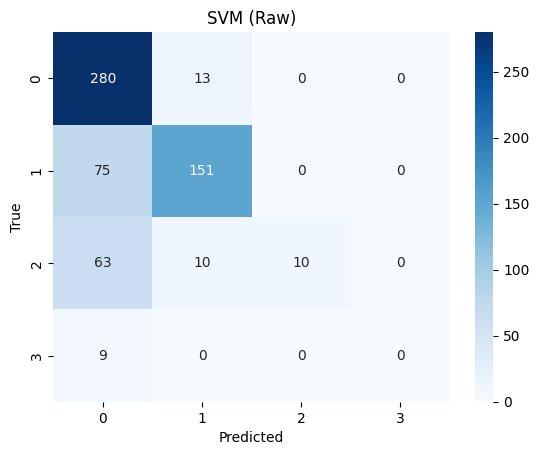

In [35]:
# Plot confusion matrix for Logistic Regression with raw predictions
plot_conf_matrix(y_test, pred_lr_raw, "Logistic Regression (Raw)")  # Logistic Regression confusion matrix

# Plot confusion matrix for Random Forest with raw predictions
plot_conf_matrix(y_test, pred_rf_raw, "Random Forest (Raw)")  # Random Forest confusion matrix

# Plot confusion matrix for SVM with raw predictions
plot_conf_matrix(y_test, pred_svm_raw, "SVM (Raw)")  # SVM confusion matrix


## ⚙️ 10. Feature Engineering from EEG Signals


In [34]:
# Define a function to extract statistical features from EEG data
def extract_features(data):
    means = np.mean(data, axis=2)  # Mean across time dimension
    stds = np.std(data, axis=2)    # Standard deviation across time
    maxs = np.max(data, axis=2)    # Max value across time
    mins = np.min(data, axis=2)    # Min value across time
    return np.concatenate([means, stds, maxs, mins], axis=1)  # Combine all features

# Apply feature extraction to train and test sets
x_train_feat = extract_features(x_train)
x_test_feat = extract_features(x_test)

# ✅ Print shape of extracted features
print("✅ Features extracted:")
print("x_train_feat shape:", x_train_feat.shape)
print("x_test_feat shape:", x_test_feat.shape)


✅ Features extracted:
x_train_feat shape: (5499, 76)
x_test_feat shape: (611, 76)


## ⚖️ 11. Feature Scaling


In [33]:
# 🔄 Standardize features (mean=0, std=1)
scaler = StandardScaler()  # Initialize the scaler
x_train_scaled = scaler.fit_transform(x_train_feat)  # Fit and transform training data
x_test_scaled = scaler.transform(x_test_feat)  # Transform test data using same scaler


## 🔄 12. Apply SMOTE to Balance Classes


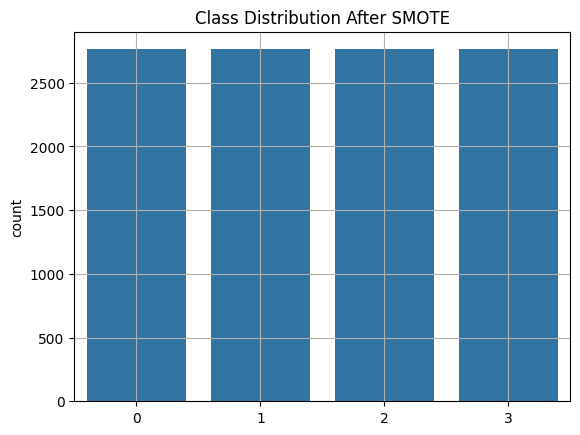

In [32]:
# Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
x_train_bal, y_train_bal = smote.fit_resample(x_train_scaled, y_train)

# 🧮 Visualize Balanced Class Distribution
sns.countplot(x=y_train_bal)  # Plot class distribution after SMOTE
plt.title("Class Distribution After SMOTE")  # Set plot title
plt.grid(True)  # Show grid lines
plt.show()  # Display the plot


##  🧪 13. Define Training Function for Feature Engineered Data


In [31]:
def train_model_balanced(model, name):
    # Train the model on balanced data
    model.fit(x_train_bal, y_train_bal)

    # Make predictions on the test set
    y_pred = model.predict(x_test_scaled)

    # Calculate weighted F1 score
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Print F1 score and classification report
    print(f"📊 {name} F1 Score (Balanced): {f1:.4f}")
    print(classification_report(y_test, y_pred))

    # Return predictions and F1 score
    return y_pred, f1



## 🧠 14. Train Models on Feature-Engineered & Balanced Data


In [17]:
pred_lr_feat, f1_lr_feat = train_model_balanced(lr, "Logistic Regression")
pred_rf_feat, f1_rf_feat = train_model_balanced(rf, "Random Forest")
pred_svm_feat, f1_svm_feat = train_model_balanced(svm, "SVM")

📊 Logistic Regression F1 Score (Balanced): 0.8871
              precision    recall  f1-score   support

           0       0.89      0.88      0.88       293
           1       0.92      0.86      0.89       226
           2       0.81      0.98      0.89        83
           3       1.00      1.00      1.00         9

    accuracy                           0.89       611
   macro avg       0.90      0.93      0.91       611
weighted avg       0.89      0.89      0.89       611

📊 Random Forest F1 Score (Balanced): 0.9375
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       293
           1       0.96      0.89      0.92       226
           2       0.94      1.00      0.97        83
           3       1.00      1.00      1.00         9

    accuracy                           0.94       611
   macro avg       0.96      0.96      0.96       611
weighted avg       0.94      0.94      0.94       611

📊 SVM F1 Score (Balanced): 0.8961
  

## 📊 15. Confusion Matrices for Balanced Models


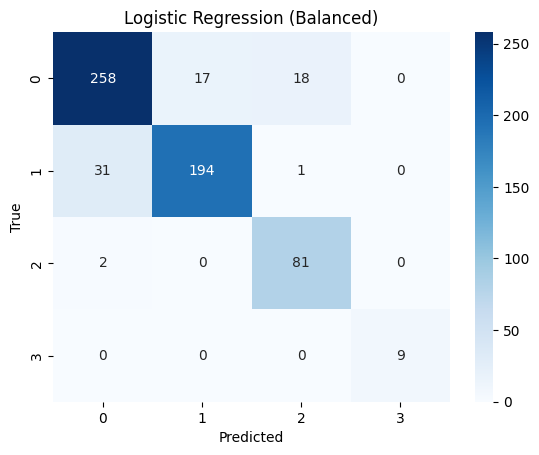

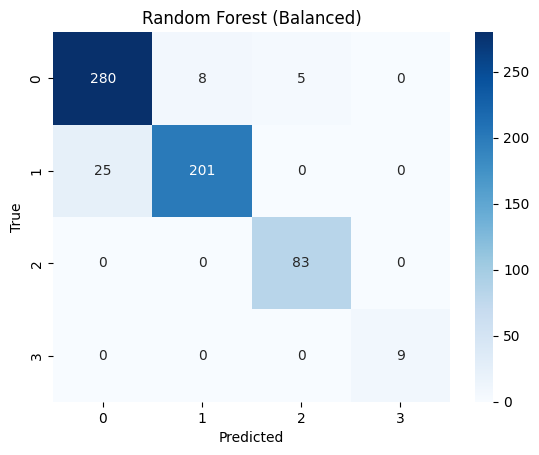

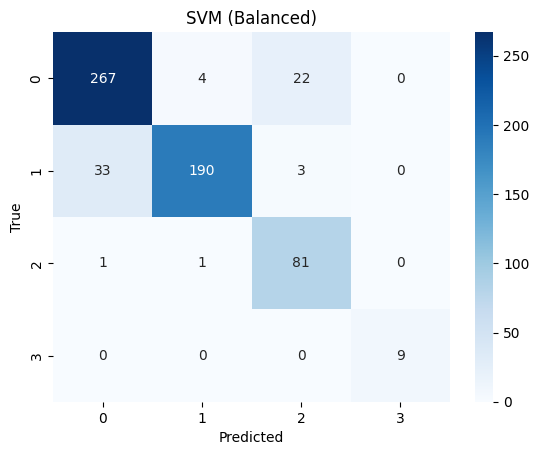

In [30]:
# Plot confusion matrix for Logistic Regression on the balanced and feature-engineered dataset
plot_conf_matrix(y_test, pred_lr_feat, "Logistic Regression (Balanced)")

# Plot confusion matrix for Random Forest on the balanced and feature-engineered dataset
plot_conf_matrix(y_test, pred_rf_feat, "Random Forest (Balanced)")

# Plot confusion matrix for SVM on the balanced and feature-engineered dataset
plot_conf_matrix(y_test, pred_svm_feat, "SVM (Balanced)")


## 📈 16. Compare Model Performance in a Table


🔍 Final Comparison:
                 Model  F1 Score (Raw)  F1 Score (Balanced)
0  Logistic Regression        0.447490             0.887100
1        Random Forest        0.871638             0.937495
2                  SVM        0.681454             0.896133


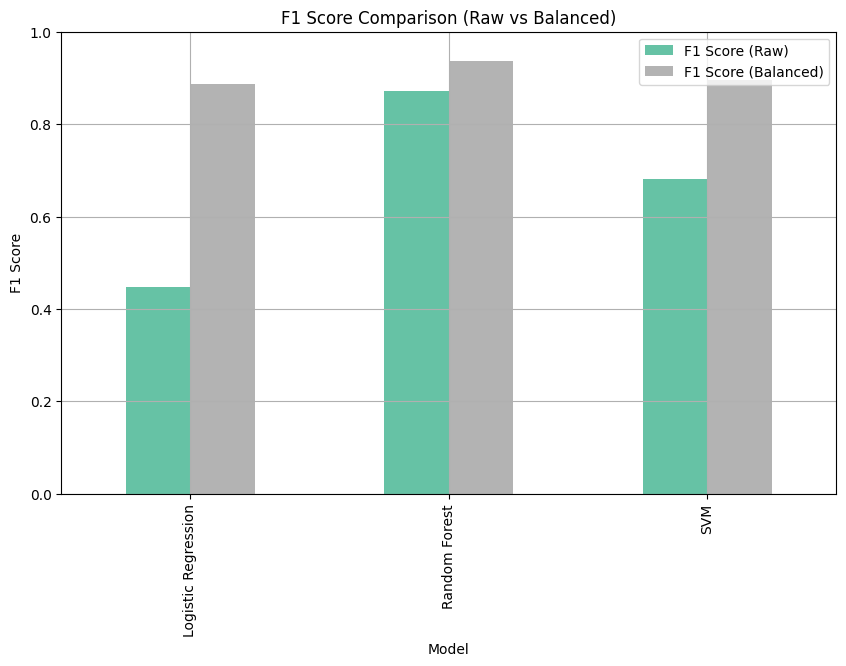

In [29]:
# Create a DataFrame to compare F1 scores of different models before and after data balancing + feature engineering
results = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest", "SVM"],
    "F1 Score (Raw)": [f1_lr_raw, f1_rf_raw, f1_svm_raw],             # F1 scores on the raw/original dataset
    "F1 Score (Balanced)": [f1_lr_feat, f1_rf_feat, f1_svm_feat]      # F1 scores after applying SMOTE & feature engineering
})

# Print the comparison table for a clear textual view of performance change
print("🔍 Final Comparison:")
print(results)

# Plot a bar chart to visually compare the performance of models before and after balancing
results.set_index("Model").plot(
    kind='bar',
    figsize=(10, 6),
    colormap='Set2'  # Sets a colorful but soft color palette
)

# Add chart elements for clarity
plt.title("F1 Score Comparison (Raw vs Balanced)")  # Title of the plot
plt.ylabel("F1 Score")                              # Label for Y-axis
plt.ylim(0, 1)                                      # Sets Y-axis scale from 0 to 1
plt.grid(True)                                      # Enables gridlines for better readability
plt.show()                                          # Display the plot
